In [1]:
file_path_cif = 'real_inputs/yMRC1_sep9.cif'
file_path_cif_2 = 'real_inputs/5mrc_aligned.cif'

output_file_path = file_path_cif_2.split(".cif")[0] + "_with_cols.cif"

# Fix columns for gemmi reading
with open(file_path_cif_2, 'r') as input_file, open(output_file_path, 'w') as output_file:
    ready_for_atoms = False
    for line in input_file:
        if line.startswith('ATOM') or line.startswith('HETATM'):
            output_file.write(line.rsplit(maxsplit = 2)[0] + ' ' + line.split()[8].ljust(4) + ' ' + 
                              line.split()[5].ljust(3) + ' ' + line.split()[16].ljust(2) + ' ' + 
                              line.split()[3].ljust(4) + ' ' + line.split()[17].ljust(2) + '\n')
            ready_for_atoms = False
        elif not ready_for_atoms:
            if line.startswith('_atom_site.pdbx_formal_charge'):
                ready_for_atoms = True
                output_file.write("_atom_site.pdbx_formal_charge \n_atom_site.auth_seq_id \n_atom_site.auth_comp_id \n_atom_site.auth_asym_id \n_atom_site.auth_atom_id \n_atom_site.pdbx_PDB_model_num \n")
            else:
                output_file.write(line)

In [2]:
import gemmi
import pandas as pd
import inspect
import numpy as np

structure2 = gemmi.read_structure(output_file_path)

# Read in structures to dataframes
def read_in_structure(structure):
    atom_names = []
    residue_names = []
    chain_ids = []
    residue_numbers = []
    x_coords = []
    y_coords = []
    z_coords = []

    for chain in structure[0]:
        for residue in chain:
            for atom in residue:
                atom_names.append(atom.name)
                residue_names.append(residue.name)             
                chain_ids.append(chain.name)
                residue_numbers.append(residue.seqid.num)
                x_coords.append(atom.pos.x)
                y_coords.append(atom.pos.y)
                z_coords.append(atom.pos.z)

    data = {
        'AtomName': atom_names,
        'ResidueName': residue_names,
        'ChainID': chain_ids,
        'ResidueNumber': residue_numbers,
        'X': x_coords,
        'Y': y_coords,
        'Z': z_coords
    }

    df = pd.DataFrame(data)
    return df

df2 = read_in_structure(structure2)

In [3]:
# Convert chain IDs
conversion_df = pd.read_csv("real_inputs/yMRC1_chains_converter.csv")
df2['ChainID'] = df2['ChainID'].map(conversion_df.set_index('5MRC')['yMRC'])

In [4]:
structure = gemmi.read_structure(file_path_cif)

df = read_in_structure(structure)

df['structure'] = 'yMRC1'
df2['structure'] = '5MRC'
df = pd.concat([df, df2], ignore_index=True)

ssu_list = ["g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "AG", "AH", "AI", "AJ", "AK", "Z", "AA", "AB", "AC", "AD", "AE", "AF", "AL", "notexist1", "notexist2", "notexist3"]
lsu_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "a", "b", "c", "d", "e", "f"]

df['subunit'] = df['ChainID'].apply(lambda x: 'SSU' if x in ssu_list else ('LSU' if x in lsu_list else 'Neither'))

df = df[df['subunit'] != 'Neither']

In [5]:
# Find best separating plane between SSU and LSU
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

df_for_sep = df[df['structure'] == 'yMRC1']
lsu_piece = df_for_sep[df_for_sep['subunit'] == 'LSU'][['X', 'Y', 'Z']].to_numpy()
ssu_piece = df_for_sep[df_for_sep['subunit'] == 'SSU'][['X', 'Y', 'Z']].to_numpy()

X = np.vstack((lsu_piece, ssu_piece))
y = np.concatenate((np.zeros(len(lsu_piece)), np.ones(len(ssu_piece))))

svm = SVC(kernel='linear')
svm.fit(X, y)

w0, w1, w2 = svm.coef_[0]
b = svm.intercept_[0]

y_pred = svm.predict(X)
accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.9857840048803416
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    119267
         1.0       0.98      0.98      0.98     80719

    accuracy                           0.99    199986
   macro avg       0.99      0.99      0.99    199986
weighted avg       0.99      0.99      0.99    199986



In [6]:
df = df[df['AtomName'].isin(['CA', 'P'])]
df_sub = df[df['subunit'] == 'SSU']
df_sub['structure'].value_counts()

df_large = df[df['subunit'] == 'LSU']
df_large['structure'].value_counts()

grouped = df_sub.groupby('structure')
result = pd.concat([group.sort_values(by=['ChainID', 'ResidueNumber']) for name, group in grouped], ignore_index=True)

subset_1 = result.loc[result['structure'] == 'yMRC1'][['ChainID', 'ResidueNumber']]
subset_2 = result.loc[result['structure'] == '5MRC'][['ChainID', 'ResidueNumber']]

subset_1.reset_index(inplace=True, drop=True)
subset_2.reset_index(inplace=True, drop=True)

# Compare two structures and show different rows if one structure is missing atoms
if not subset_1.equals(subset_2):
    merged_df = subset_1.merge(subset_2, how='outer', indicator=True)

    in_df1_only = merged_df[merged_df['_merge'] == 'left_only']
    in_df1_only = in_df1_only.drop(columns=['_merge'])
    in_df2_only = merged_df[merged_df['_merge'] == 'right_only']
    in_df2_only = in_df2_only.drop(columns=['_merge'])

    print("Rows unique to df1:")
    print(in_df1_only)

    print("\nRows unique to df2:")
    print(in_df2_only)

Rows unique to df1:
     ChainID  ResidueNumber
127       AB            129
128       AB            130
222       AC            101
223       AC            102
224       AC            103
...      ...            ...
6798       u            124
6799       u            125
6800       u            126
6801       u            127
6961       v              1

[338 rows x 2 columns]

Rows unique to df2:
     ChainID  ResidueNumber
7534      AB             30
7535      AB             31
7536      AB             32
7537      AB             33
7538      AB             34
...      ...            ...
8338       v            116
8339       v            117
8340       v            118
8341       v            119
8342       v            120

[809 rows x 2 columns]


In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor

subset_1_df = result.loc[result['structure'] == 'yMRC1']
subset_2_df = result.loc[result['structure'] == '5MRC']

# Drop non-matching rows
merged_df = subset_1_df.merge(in_df1_only, on=['ChainID', 'ResidueNumber'], how='left', indicator=True)
subset_1_df = merged_df[merged_df['_merge'] == 'left_only']
subset_1_df = subset_1_df.drop(columns=['_merge'])
merged_df = subset_2_df.merge(in_df2_only, on=['ChainID', 'ResidueNumber'], how='left', indicator=True)
subset_2_df = merged_df[merged_df['_merge'] == 'left_only']
subset_2_df = subset_2_df.drop(columns=['_merge'])

subset_1_df.reset_index(inplace=True, drop=True)
subset_2_df.reset_index(inplace=True, drop=True)

# Convert to coordinate array
subset_1 = subset_1_df[['X', 'Y', 'Z']].to_numpy()
subset_2 = subset_2_df[['X', 'Y', 'Z']].to_numpy()

subset_3 = df_large.loc[(df_large['structure'] == 'yMRC1') & (df_large['subunit'] == 'LSU')]
subset_3 = subset_3[['X', 'Y', 'Z']].to_numpy()

def gram_schmidt(v):
    u1 = v / np.linalg.norm(v)
    v2 = np.array([0.42453173, 0.852023695, 0.30631427])
    u2 = v2 - np.dot(v2, u1) * u1
    u2 /= np.linalg.norm(u2)
    u3 = np.cross(u1, u2)    
    return u1, u2, u3

def project_onto_plane(points, normal_vector, bias):
    normalized_normal = normal_vector / np.linalg.norm(normal_vector)
    u1, u2, u3 = gram_schmidt(normalized_normal)
    return np.column_stack((points.dot(u2), points.dot(u3)))

# Define the normal vector and bias of the plane
normal_vector = svm.coef_[0]
bias = svm.intercept_[0]

projected_subset_1 = project_onto_plane(subset_1, normal_vector, bias)
projected_subset_2 = project_onto_plane(subset_2, normal_vector, bias)

In [8]:
# Keep body only
head_chains = conversion_df['yMRC'][conversion_df['head'] == 1].to_list()

projected_subset_1_body = projected_subset_1[~subset_1_df['ChainID'].isin(head_chains)]
projected_subset_2_body = projected_subset_2[~subset_2_df['ChainID'].isin(head_chains)]

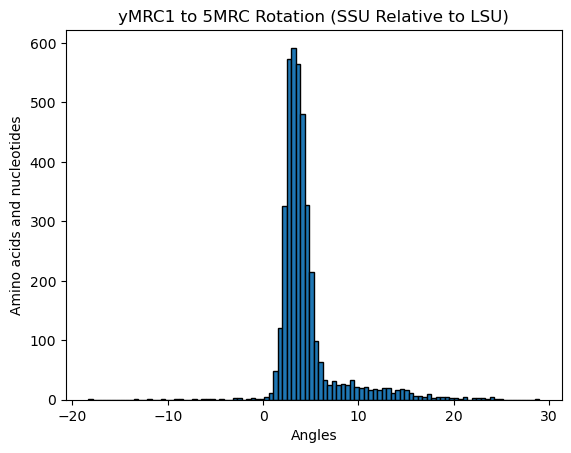

Mean angle: 4.497 degrees


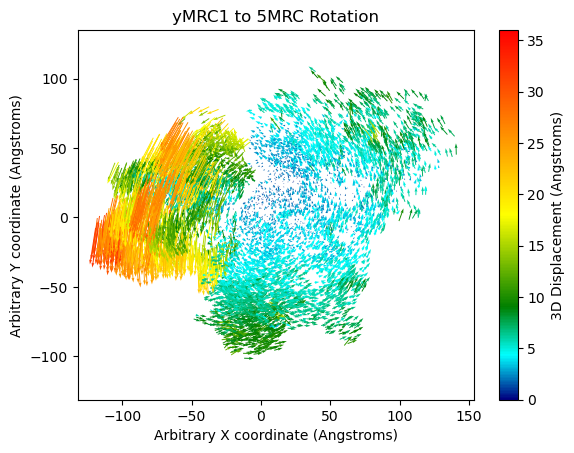

In [9]:
from scipy.optimize import minimize

################################
# Calculate angles of rotation #
################################

# Optimization function for choosing the center
def center_loss(center, projected_subset_1, projected_subset_2):
    piece_1 = center - projected_subset_1
    piece_2 = projected_subset_2 - projected_subset_1
    angles = np.arctan2(piece_1[:,1], piece_1[:,0]) - np.arctan2(piece_2[:,1], piece_2[:,0])
    angles = np.mod(angles + np.pi, 2 * np.pi) - np.pi
    return np.sum(np.abs(np.abs(angles) - np.pi/2))

# 3D distances
magnitudes = np.sqrt(np.sum(np.square(subset_1 - subset_2), axis=1))
magnitudes_body = magnitudes[~subset_1_df['ChainID'].isin(head_chains)]

# Choose best center
result = minimize(center_loss, [370, 150], # Initial center guess
                  args=(projected_subset_1_body[magnitudes_body > 3], projected_subset_2_body[magnitudes_body > 3]),
                 method = 'Nelder-Mead',)

if result['success']:
    best_center = result['x']
else:
    raise ValueError("Failed to converge")
    
best_center = np.mean(projected_subset_1, axis=0)
    
# Determine the angles
def best_angle(center, projected_subset_1, projected_subset_2):
    piece_1 = projected_subset_1 - center
    piece_2 = projected_subset_2 - center
    angles = np.arctan2(piece_2[:,1], piece_2[:,0]) - np.arctan2(piece_1[:,1], piece_1[:,0])
    angles = np.mod(angles + np.pi, 2 * np.pi) - np.pi
    return angles

# Histogram of angles
angles = best_angle(best_center, projected_subset_1_body[magnitudes_body > 3], projected_subset_2_body[magnitudes_body > 3]) * 180 / np.pi
plt.hist(angles, bins=100, edgecolor='black')
plt.title('yMRC1 to 5MRC Rotation (SSU Relative to LSU)')
plt.xlabel("Angles")
plt.ylabel('Amino acids and nucleotides')
plt.savefig('outputs/yMRC1_to_5MRC_X_Y_angles.pdf', format="pdf", dpi=3000, bbox_inches='tight')
plt.show()

print("Mean angle: " + str(np.round(np.mean(angles), 3)) + ' degrees')

# Center the projections
x = projected_subset_1[:, 0] - best_center[0]
y = projected_subset_1[:, 1] - best_center[1]
x2 = projected_subset_2[:, 0] - best_center[0]
y2 = projected_subset_2[:, 1] - best_center[1]

cmap = mcolor.LinearSegmentedColormap.from_list('colors',
                                                [(0, 'navy'),
                                              (0.12, 'cyan'),
                                              (0.25, 'green'),
                                              (0.5, 'yellow'),
                                              (1, 'red')], N=256)

# Create a vector plot
plt.quiver(x, y, x2-x, y2-y, magnitudes, angles='xy', scale_units='xy', scale=1, cmap=cmap)

plt.axis('equal')
plt.xlabel('Arbitrary X coordinate (Angstroms)')
plt.ylabel('Arbitrary Y coordinate (Angstroms)')
plt.title('yMRC1 to 5MRC Rotation')
plt.colorbar(label='3D Displacement (Angstroms)')
plt.clim(0,36)

plt.savefig('outputs/yMRC1_to_5MRC_X_Y_rotation.pdf', format="pdf", dpi=3000, bbox_inches='tight')
plt.show()

In [14]:
import plotly.graph_objects as go
import imageio

###############
# 3D Plotting #
###############

x_mean = np.mean(subset_1[:, 0])
y_mean = np.mean(subset_1[:, 1])
z_mean = np.mean(subset_1[:, 2])

plot_subset_1 = subset_1 - np.mean(subset_1, axis=0)
plot_subset_3 = subset_3 - np.mean(subset_1, axis=0)

atom_shifts = (subset_2 - subset_1)

# Create a cone plot
cone_trace = go.Cone(
    x=plot_subset_1[:, 0],
    y=plot_subset_1[:, 1],
    z=plot_subset_1[:, 2],
    u=atom_shifts[:, 0],
    v=atom_shifts[:, 1],
    w=atom_shifts[:, 2],
    sizemode="absolute",
    sizeref=80,
    showscale=True
)

# Create a point cloud of all LSU atoms
gray_spheres_trace = go.Scatter3d(
    x=plot_subset_3[:, 0],
    y=plot_subset_3[:, 1],
    z=plot_subset_3[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color='gray',
        opacity=0.3
    )
)

fig = go.Figure(data=[cone_trace, gray_spheres_trace])

frame = 0

frames = 60
rotation_angle = 360 / frames
fig.update_layout(scene_camera=dict(eye=dict(x=-0.5*np.cos(np.radians((frame + 7)*rotation_angle)),
                                                  y=0.5*np.sin(np.radians((frame + 7)*rotation_angle)),
                                                  z=-1.3)))
# Check the orientation looks right
fig.show()

# Switch to final plotting view
fig.update_scenes(xaxis_visible=False, yaxis_visible=False ,zaxis_visible=False)
fig.update_layout(
    legend_title="Shift (Angstroms)",
    font=dict(
        size=48,
    )
)

frames = 60
rotation_angle = 360 / frames

frames_list = []

# Rotate up from vertical view first
steps = 10
for step in range(steps):
    fig.update_layout(scene_camera=dict(eye=dict(x=(-1.2 * step + -0.5 * (steps - step))/steps * np.cos(np.radians((frame + 7)*rotation_angle)),
                                             y=(1.2 * step + 0.5 * (steps - step))/steps*np.sin(np.radians((frame + 7)*rotation_angle)),
                                             z=(-0.4 * step + -1.3 * (steps - step))/steps)))
    frame_image = go.Figure(fig).to_image(format="png", width=2400, height=1600)
    frames_list.append(imageio.imread(frame_image))
    
    # Store start frame
    if step == 0:
        go.Figure(fig).to_image(format="pdf", width=2400, height=1600)
        fig.write_image('outputs/yMRC1_to_5MRC_3D_rotation_start.pdf', width=2400, height=1600)


# Then spin around the structure
for frame in range(frames):
    frame = (frame + 7) % 60
    print(frame)
    fig.update_layout(scene_camera=dict(eye=dict(x=-1.2*np.cos(np.radians(frame*rotation_angle)),
                                                 y=1.2*np.sin(np.radians(frame*rotation_angle)),
                                                 z=-0.4)))
    frame_image = go.Figure(fig).to_image(format="png", width=2400, height=1600)
    frames_list.append(imageio.imread(frame_image))
    
# Then rotate it around the axis defining the plane of separation
rot_vec = np.array([w0, w1, w2]) / np.linalg.norm(np.array([w0, w1, w2]))
        
K = np.array([[0, -rot_vec[2], rot_vec[1]],
              [rot_vec[2], 0, -rot_vec[0]],
              [-rot_vec[1], rot_vec[0], 0]])
    
start_vec = np.array([-1.2*np.cos(np.radians(5*rotation_angle)), 
              1.2*np.sin(np.radians(5*rotation_angle)),
              -0.4])
    
for frame in range(frames):
    frame = (frame + 7) % 60
    
    R = np.eye(3) + np.sin(np.radians(frame*rotation_angle)) * K + (1 - np.cos(np.radians(frame*rotation_angle))) * np.dot(K, K)
    cur_vec = start_vec.dot(R)
    
    print(frame)
    fig.update_layout(scene_camera=dict(eye=dict(x=cur_vec[0],
                                                 y=cur_vec[1],
                                                 z=cur_vec[2])))
    frame_image = go.Figure(fig).to_image(format="png", width=2400, height=1600)
    frames_list.append(imageio.imread(frame_image))

imageio.mimsave('outputs/yMRC1_to_5MRC_3D_rotation.gif', frames_list, duration=0.2)

/var/folders/sd/kt91y68x51v580jtrx05xmjw0000gn/T/ipykernel_45928/1177337409.py:76: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/williamnickols/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/sd/kt91y68x51v580jtrx05xmjw0000gn/T/ipykernel_45928/1177337409.py", line 75, in <module>
    frame_image = go.Figure(fig).to_image(format="png", width=2400, height=1600)
  File "/Users/williamnickols/opt/anaconda3/lib/python3.9/site-packages/plotly/basedatatypes.py", line 3766, in to_image
    return pio.to_image(self, *args, **kwargs)
  File "/Users/williamnickols/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_kaleido.py", line 144, in to_image
    img_bytes = scope.transform(
  File "/Users/williamnickols/opt/anaconda3/lib/python3.9/site-packages/kaleido/scopes/plotly.py", line 153, in transform
    response = self._perform_transform(
  File "/Users/williamnickols/opt/anaconda3/lib/python3.9/site-packages/kaleido/scopes/base.py", line 308, in

TypeError: object of type 'NoneType' has no len()

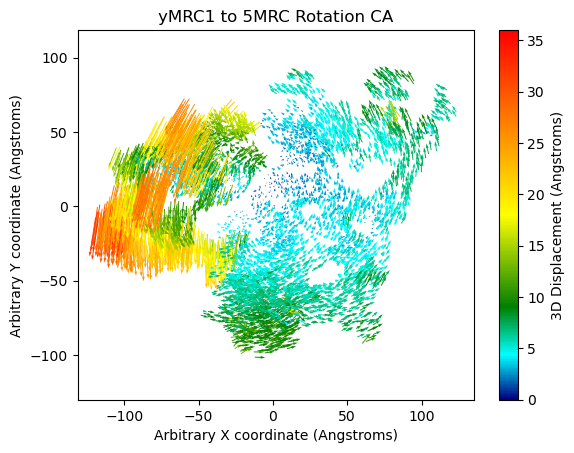

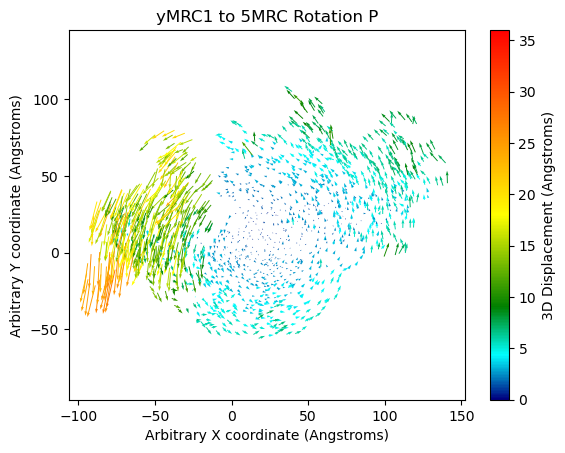

In [11]:
# Same as earlier but only with P and CA
def show_subset(atom_type):
    subset_1_tmp = subset_1[subset_1_df['AtomName'] == atom_type, :]
    subset_2_tmp = subset_2[subset_2_df['AtomName'] == atom_type, :]
    magnitudes_tmp = magnitudes[subset_2_df['AtomName'] == atom_type]
        
    normal_vector = svm.coef_[0]
    bias = svm.intercept_[0]

    projected_subset_1 = project_onto_plane(subset_1_tmp, normal_vector, bias)
    projected_subset_2 = project_onto_plane(subset_2_tmp, normal_vector, bias)
        
    x = projected_subset_1[:, 0] - best_center[0]
    y = projected_subset_1[:, 1] - best_center[1]
    x2 = projected_subset_2[:, 0] - best_center[0]
    y2 = projected_subset_2[:, 1] - best_center[1]
    
    
    cmap = mcolor.LinearSegmentedColormap.from_list('colors',
                                                    [(0, 'navy'),
                                                  (0.12, 'cyan'),
                                                  (0.25, 'green'),
                                                  (0.5, 'yellow'),
                                                  (1, 'red')], N=256)

    # Create a vector plot
    plt.quiver(x, y, x2-x, y2-y, magnitudes_tmp, angles='xy', scale_units='xy', scale=1, cmap=cmap)

    plt.axis('equal')
    plt.xlabel('Arbitrary X coordinate (Angstroms)')
    plt.ylabel('Arbitrary Y coordinate (Angstroms)')
    plt.title('yMRC1 to 5MRC Rotation ' + atom_type)
    plt.colorbar(label='3D Displacement (Angstroms)')
    plt.clim(0,36)

    plt.savefig('outputs/yMRC1_to_5MRC_X_Y_rotation_' + atom_type + '.pdf', format="pdf", dpi=3000, bbox_inches='tight')
    plt.show()

atom_types = ['CA', 'P']

for atom_type in atom_types:
    show_subset(atom_type)